## Imports and paths

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from pathlib import Path

from IPython.display import Image, display, Video, HTML


In [22]:
!tree -L 3 ..

..
├── Benoit
│   └── exploratory_data_analaysis_benoitfrisque.ipynb
├── Jan
│   ├── notebook_exploratory_data_analaysis_benoitfrisque_copy.ipynb
│   ├── notebook_exploratory_data_analaysis_benoitfrisque_newer.ipynb
│   ├── notebook_exploratory_data_analaysis_Jan balancing_.ipynb
│   ├── notebook_exploratory_data_analaysis_Jan.ipynb
│   ├── notebook_exploratory_data_analysis_balancing.ipynb
│   └── video_conversion_benoitfrisque.ipynb
├── Max
│   └── nb_exploratory_data_analaysis_MaxGrieb.ipynb
└── Wail
    └── notebook_exploratory_data_analaysis_wail.ipynb

4 directories, 9 files


In [23]:
DATA_DIR         = Path('../../raw_data/asl-signs')
TRAIN_CSV_PATH   = DATA_DIR/'train.csv'
LANDMARK_DIR     = DATA_DIR/'train_landmark_files'
LABEL_MAP_PATH   = DATA_DIR/'sign_to_prediction_index_map.json'

## Data description

**Files**

**train_landmark_files/[participant_id]/[sequence_id].parquet** The landmark data. The landmarks were extracted from raw videos with the MediaPipe holistic model. Not all of the frames necessarily had visible hands or hands that could be detected by the model.

Landmark data should not be used to identify or re-identify an individual. Landmark data is not intended to enable any form of identity recognition or store any unique biometric identification.

- `frame` - The frame number in the raw video.
- `row_id` - A unique identifier for the row.
- `type` - The type of landmark. One of ['face', 'left_hand', 'pose', 'right_hand'].
- `landmark_index` - The landmark index number. Details of the hand landmark locations can be found here.
- `[x/y/z]` - The normalized spatial coordinates of the landmark. These are the only columns that will be provided to your submitted model for inference. The MediaPipe model is not fully trained to predict depth so you may wish to ignore the z values.

**train.csv**

- `path` - The path to the landmark file.
- `participant_id` - A unique identifier for the data contributor.
- `sequence_id` - A unique identifier for the landmark sequence.
- `sign` - The label for the landmark sequence.

## List of videos

In [24]:
train = pd.read_csv(TRAIN_CSV_PATH)
train["path"]=train["path"].str.replace('landmark_files', 'landmark_files_light')

In [25]:
train.nunique()

path              94477
participant_id       21
sequence_id       94477
sign                250
dtype: int64

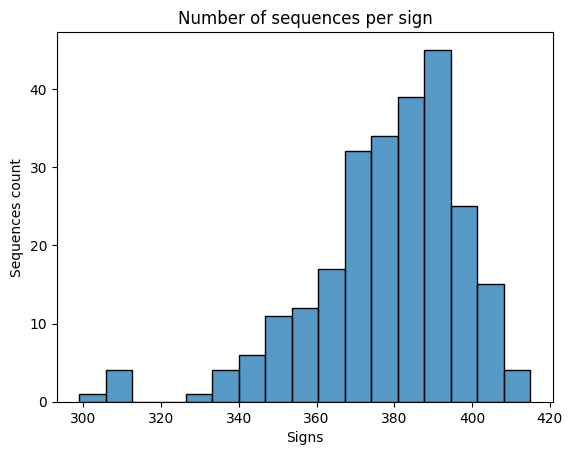

In [26]:
sns.histplot(train[['sign']].value_counts())
plt.title('Number of sequences per sign')
plt.xlabel('Signs')
plt.ylabel('Sequences count');

## List of signs

In [27]:
train

,path,participant_id,sequence_id,sign
0,train_landmark_files_light/26734/1000035562.pa...,26734,1000035562,blow
1,train_landmark_files_light/28656/1000106739.pa...,28656,1000106739,wait
2,train_landmark_files_light/16069/100015657.par...,16069,100015657,cloud
3,train_landmark_files_light/25571/1000210073.pa...,25571,1000210073,bird
4,train_landmark_files_light/62590/1000240708.pa...,62590,1000240708,owie
...,...,...,...,...
94472,train_landmark_files_light/53618/999786174.par...,53618,999786174,white
94473,train_landmark_files_light/26734/999799849.par...,26734,999799849,have
94474,train_landmark_files_light/25571/999833418.par...,25571,999833418,flower
94475,train_landmark_files_light/29302/999895257.par...,29302,999895257,room


In [28]:
labels_df = pd.read_json(LABEL_MAP_PATH, orient='index').reset_index().set_index(0).rename(columns={'index':'sign'})
labels_df.index.rename('index', inplace=True)
labels_df

,sign
index,
0,TV
1,after
2,airplane
3,all
4,alligator
...,...
245,yesterday
246,yourself
247,yucky


## Analysis of landmark files

In [32]:
train=load_subset_data()

In [33]:
train.loc[2, "file_path"]

'../../raw_data/asl-signs/train_landmark_files_noface/16069/100015657.parquet'

In [34]:
data = pd.read_parquet(train.loc[0, "file_path"])
data

,frame,row_id,type,landmark_index,x,y,z
468,20,20-left_hand-0,left_hand,0,NaN,NaN,NaN
469,20,20-left_hand-1,left_hand,1,NaN,NaN,NaN
470,20,20-left_hand-2,left_hand,2,NaN,NaN,NaN
471,20,20-left_hand-3,left_hand,3,NaN,NaN,NaN
472,20,20-left_hand-4,left_hand,4,NaN,NaN,NaN
...,...,...,...,...,...,...,...
12484,42,42-right_hand-16,right_hand,16,0.001660,0.549574,-0.145409
12485,42,42-right_hand-17,right_hand,17,0.042694,0.693116,-0.085307
12486,42,42-right_hand-18,right_hand,18,0.006723,0.665044,-0.114017
12487,42,42-right_hand-19,right_hand,19,-0.014755,0.643799,-0.123488


In [35]:
# Source: https://www.kaggle.com/competitions/asl-signs/overview/evaluation
ROWS_PER_FRAME = 75

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [36]:
data_clean = load_relevant_data_subset(train.loc[0, "file_path"])
data_clean

array([[[        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        ...,
        [ 0.31373617,  0.41234398, -0.05269891],
        [ 0.35072815,  0.39958185, -0.06021732],
        [ 0.38579622,  0.4011007 , -0.06471767]],

       [[        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        ...,
        [ 0.33588555,  0.3889878 , -0.0631762 ],
        [ 0.37742943,  0.3802519 , -0.07176355],
        [ 0.41639116,  0.38289747, -0.076529  ]],

       [[        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan],
        ...,
        [ 0.35855788,  0.3844513 , -0.06097187],
        [ 0.4005313 ,  0.37769613, -0.07045607],
        [ 0.43907768,  0.37987   , -0.07860945]],

       ...,

       [[        nan,         nan,         nan],
        [  

In [37]:
data_clean = load_relevant_data_subset(train.loc[0, "file_path"])
data_clean.shape # number of frames, number of landmarks, # coordinates (x, y, z)

(23, 75, 3)

In [ ]:
# # Source: https://www.kaggle.com/competitions/asl-signs/overview/evaluation
# import tflite_runtime.interpreter as tflite
# interpreter = tflite.Interpreter(model_path)

# found_signatures = list(interpreter.get_signature_list().keys())

# if REQUIRED_SIGNATURE not in found_signatures:
#     raise KernelEvalException('Required input signature not found.')

# prediction_fn = interpreter.get_signature_runner("serving_default")
# output = prediction_fn(inputs=frames)
# sign = np.argmax(output["outputs"])


### Landmarks visualization (animation)

In [38]:
def get_hand_points(hand):
    x = [[hand.iloc[0].x, hand.iloc[1].x, hand.iloc[2].x, hand.iloc[3].x, hand.iloc[4].x], # Thumb
         [hand.iloc[5].x, hand.iloc[6].x, hand.iloc[7].x, hand.iloc[8].x], # Index
         [hand.iloc[9].x, hand.iloc[10].x, hand.iloc[11].x, hand.iloc[12].x],
         [hand.iloc[13].x, hand.iloc[14].x, hand.iloc[15].x, hand.iloc[16].x],
         [hand.iloc[17].x, hand.iloc[18].x, hand.iloc[19].x, hand.iloc[20].x],
         [hand.iloc[0].x, hand.iloc[5].x, hand.iloc[9].x, hand.iloc[13].x, hand.iloc[17].x, hand.iloc[0].x]]

    y = [[hand.iloc[0].y, hand.iloc[1].y, hand.iloc[2].y, hand.iloc[3].y, hand.iloc[4].y],  #Thumb
         [hand.iloc[5].y, hand.iloc[6].y, hand.iloc[7].y, hand.iloc[8].y], # Index
         [hand.iloc[9].y, hand.iloc[10].y, hand.iloc[11].y, hand.iloc[12].y],
         [hand.iloc[13].y, hand.iloc[14].y, hand.iloc[15].y, hand.iloc[16].y],
         [hand.iloc[17].y, hand.iloc[18].y, hand.iloc[19].y, hand.iloc[20].y],
         [hand.iloc[0].y, hand.iloc[5].y, hand.iloc[9].y, hand.iloc[13].y, hand.iloc[17].y, hand.iloc[0].y]]

    return x, y

def get_pose_points(pose):
    x = [[pose.iloc[8].x, pose.iloc[6].x, pose.iloc[5].x, pose.iloc[4].x, pose.iloc[0].x, pose.iloc[1].x, pose.iloc[2].x, pose.iloc[3].x, pose.iloc[7].x],
         [pose.iloc[10].x, pose.iloc[9].x],
         [pose.iloc[22].x, pose.iloc[16].x, pose.iloc[20].x, pose.iloc[18].x, pose.iloc[16].x, pose.iloc[14].x, pose.iloc[12].x,
          pose.iloc[11].x, pose.iloc[13].x, pose.iloc[15].x, pose.iloc[17].x, pose.iloc[19].x, pose.iloc[15].x, pose.iloc[21].x],
         [pose.iloc[12].x, pose.iloc[24].x, pose.iloc[26].x, pose.iloc[28].x, pose.iloc[30].x, pose.iloc[32].x, pose.iloc[28].x],
         [pose.iloc[11].x, pose.iloc[23].x, pose.iloc[25].x, pose.iloc[27].x, pose.iloc[29].x, pose.iloc[31].x, pose.iloc[27].x],
         [pose.iloc[24].x, pose.iloc[23].x]
        ]

    y = [[pose.iloc[8].y, pose.iloc[6].y, pose.iloc[5].y, pose.iloc[4].y, pose.iloc[0].y, pose.iloc[1].y, pose.iloc[2].y, pose.iloc[3].y, pose.iloc[7].y],
         [pose.iloc[10].y, pose.iloc[9].y],
         [pose.iloc[22].y, pose.iloc[16].y, pose.iloc[20].y, pose.iloc[18].y, pose.iloc[16].y, pose.iloc[14].y, pose.iloc[12].y,
          pose.iloc[11].y, pose.iloc[13].y, pose.iloc[15].y, pose.iloc[17].y, pose.iloc[19].y, pose.iloc[15].y, pose.iloc[21].y],
         [pose.iloc[12].y, pose.iloc[24].y, pose.iloc[26].y, pose.iloc[28].y, pose.iloc[30].y, pose.iloc[32].y, pose.iloc[28].y],
         [pose.iloc[11].y, pose.iloc[23].y, pose.iloc[25].y, pose.iloc[27].y, pose.iloc[29].y, pose.iloc[31].y, pose.iloc[27].y],
         [pose.iloc[24].y, pose.iloc[23].y]
        ]

    return x, y

In [ ]:
data = pd.read_parquet(train.loc[128, "file_path"])
sign = data
sign.y = sign.y * -1 # reverse vertically

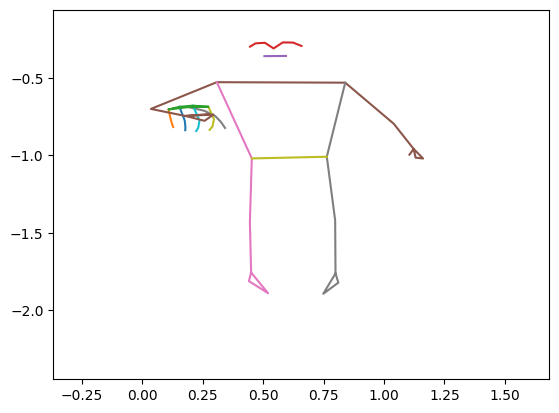

In [ ]:

def animation_frame(f):
    frame = sign[sign.frame==f]
    left = frame[frame.type=='left_hand']
    right = frame[frame.type=='right_hand']
    pose = frame[frame.type=='pose']
    face = frame[frame.type=='face'][['x', 'y']].values
    lx, ly = get_hand_points(left)
    rx, ry = get_hand_points(right)
    px, py = get_pose_points(pose)
    ax.clear()
    ax.plot(face[:,0], face[:,1], '.')
    for i in range(len(lx)):
        ax.plot(lx[i], ly[i])
    for i in range(len(rx)):
        ax.plot(rx[i], ry[i])
    for i in range(len(px)):
        ax.plot(px[i], py[i])
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

## These values set the limits on the graph to stabilize the video
xmin = sign.x.min() - 0.2
xmax = sign.x.max() + 0.2
ymin = sign.y.min() - 0.2
ymax = sign.y.max() + 0.2

fig, ax = plt.subplots(1)
l, = ax.plot([], [])
animation = FuncAnimation(fig,
                          func=animation_frame, frames=sign.frame.unique())

HTML(animation.to_html5_video())

In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense,Masking, Flatten
from tensorflow.keras.callbacks import EarlyStopping

2024-03-19 16:02:30.630052: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-19 16:02:31.587730: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-19 16:02:34.302418: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [40]:
len(labels_df)

250

In [41]:
num_classes=len(labels_df)



model = Sequential()
model.add(TimeDistributed(Flatten(), input_shape=(1,100, 75, 3)))
model.add(LSTM(units=128))




model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/home/wailmouro/.pyenv/versions/3.10.6/envs/signlens/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-03-19 16:02:42.125599: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-19 16:02:42.127451: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [156]:
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_10             │ (None, 100, 225)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 128)            │       181,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 250)            │        32,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 213,498 (833.98 KB)

 Trainable params: 213,498 (833.98 KB)

 Non-trainable params: 0 (0.00 B)

In [158]:
es = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)
#model.fit(train_data, train_labels, epochs=10, batch_size=32, validation_data=(val_data, val_labels),callbacks=[es])

In [94]:
data_clean.shape

(23, 75, 3)

In [98]:
train

,path,participant_id,sequence_id,sign,file_path
0,train_landmark_files_light/26734/1000035562.pa...,26734,1000035562,blow,../raw_data/train_landmark_files_light/train_l...
1,train_landmark_files_light/28656/1000106739.pa...,28656,1000106739,wait,../raw_data/train_landmark_files_light/train_l...
2,train_landmark_files_light/16069/100015657.par...,16069,100015657,cloud,../raw_data/train_landmark_files_light/train_l...
3,train_landmark_files_light/25571/1000210073.pa...,25571,1000210073,bird,../raw_data/train_landmark_files_light/train_l...
4,train_landmark_files_light/62590/1000240708.pa...,62590,1000240708,owie,../raw_data/train_landmark_files_light/train_l...
...,...,...,...,...,...
94472,train_landmark_files_light/53618/999786174.par...,53618,999786174,white,../raw_data/train_landmark_files_light/train_l...
94473,train_landmark_files_light/26734/999799849.par...,26734,999799849,have,../raw_data/train_landmark_files_light/train_l...
94474,train_landmark_files_light/25571/999833418.par...,25571,999833418,flower,../raw_data/train_landmark_files_light/train_l...
94475,train_landmark_files_light/29302/999895257.par...,29302,999895257,room,../raw_data/train_landmark_files_light/train_l...


In [113]:
for i in range(len(train)):
    df=pd.read_parquet(train.loc[i, "file_path"]).copy()
    train.at[i, "frame_parquet"]=df["frame"].iloc[-1] - df["frame"].iloc[0]+1

,path,participant_id,sequence_id,sign,file_path,frame_parquet
0,train_landmark_files_light/26734/1000035562.pa...,26734,1000035562,blow,../raw_data/train_landmark_files_light/train_l...,23
1,train_landmark_files_light/28656/1000106739.pa...,28656,1000106739,wait,../raw_data/train_landmark_files_light/train_l...,11
2,train_landmark_files_light/16069/100015657.par...,16069,100015657,cloud,../raw_data/train_landmark_files_light/train_l...,105
3,train_landmark_files_light/25571/1000210073.pa...,25571,1000210073,bird,../raw_data/train_landmark_files_light/train_l...,12
4,train_landmark_files_light/62590/1000240708.pa...,62590,1000240708,owie,../raw_data/train_landmark_files_light/train_l...,18
...,...,...,...,...,...,...
94472,train_landmark_files_light/53618/999786174.par...,53618,999786174,white,../raw_data/train_landmark_files_light/train_l...,49
94473,train_landmark_files_light/26734/999799849.par...,26734,999799849,have,../raw_data/train_landmark_files_light/train_l...,6
94474,train_landmark_files_light/25571/999833418.par...,25571,999833418,flower,../raw_data/train_landmark_files_light/train_l...,37
94475,train_landmark_files_light/29302/999895257.par...,29302,999895257,room,../raw_data/train_landmark_files_light/train_l...,34


<Axes: ylabel='Count'>

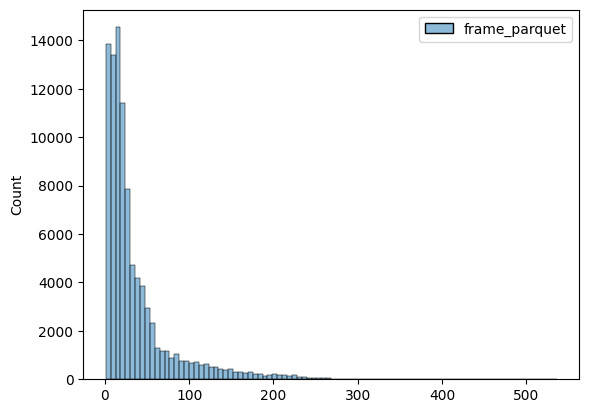

In [122]:
sns.histplot(train[['frame_parquet']],bins="rice")

In [146]:
train[train["sign"]=="bug"]

,path,participant_id,sequence_id,sign,file_path,frame_parquet
102,train_landmark_files_light/16069/1004211348.pa...,16069,1004211348,bug,../raw_data/train_landmark_files_light/train_l...,163
128,train_landmark_files_light/26734/1005029875.pa...,26734,1005029875,bug,../raw_data/train_landmark_files_light/train_l...,199
176,train_landmark_files_light/27610/1006973536.pa...,27610,1006973536,bug,../raw_data/train_landmark_files_light/train_l...,42
209,train_landmark_files_light/18796/1008404042.pa...,18796,1008404042,bug,../raw_data/train_landmark_files_light/train_l...,8
260,train_landmark_files_light/16069/1010611404.pa...,16069,1010611404,bug,../raw_data/train_landmark_files_light/train_l...,17
...,...,...,...,...,...,...
93357,train_landmark_files_light/37055/953243246.par...,37055,953243246,bug,../raw_data/train_landmark_files_light/train_l...,25
93526,train_landmark_files_light/2044/959449340.parquet,2044,959449340,bug,../raw_data/train_landmark_files_light/train_l...,14
93640,train_landmark_files_light/34503/964969098.par...,34503,964969098,bug,../raw_data/train_landmark_files_light/train_l...,6
93996,train_landmark_files_light/29302/98042717.parquet,29302,98042717,bug,../raw_data/train_landmark_files_light/train_l...,26


In [151]:
data

,frame,row_id,type,landmark_index,x,y,z
468,0,0-left_hand-0,left_hand,0,NaN,NaN,NaN
469,0,0-left_hand-1,left_hand,1,NaN,NaN,NaN
470,0,0-left_hand-2,left_hand,2,NaN,NaN,NaN
471,0,0-left_hand-3,left_hand,3,NaN,NaN,NaN
472,0,0-left_hand-4,left_hand,4,NaN,NaN,NaN
...,...,...,...,...,...,...,...
108052,198,198-right_hand-16,right_hand,16,0.449488,-0.582757,-0.085067
108053,198,198-right_hand-17,right_hand,17,0.340303,-0.587313,-0.109222
108054,198,198-right_hand-18,right_hand,18,0.420385,-0.601835,-0.113548
108055,198,198-right_hand-19,right_hand,19,0.422868,-0.602679,-0.094513


In [25]:
%load_ext autoreload
%autoreload 2
from signlens.preprocessing.preprocess_files import load_subset_data,load_relevant_data_subset, load_frame_number_parquet, filter_out_parquet_frame, pad_sequences


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
train=load_subset_data(frac=0.5)

In [84]:
train.sort_values(by="sequence_id")

,path,participant_id,sequence_id,sign,file_path
3743,train_landmark_files_noface/29302/115459.parquet,29302,115459,chocolate,../../raw_data/asl-signs/train_landmark_files_...
18218,train_landmark_files_noface/30680/175180.parquet,30680,175180,carrot,../../raw_data/asl-signs/train_landmark_files_...
25582,train_landmark_files_noface/61333/205620.parquet,61333,205620,talk,../../raw_data/asl-signs/train_landmark_files_...
41762,train_landmark_files_noface/25571/270841.parquet,25571,270841,gift,../../raw_data/asl-signs/train_landmark_files_...
47472,train_landmark_files_noface/22343/294030.parquet,22343,294030,water,../../raw_data/asl-signs/train_landmark_files_...
...,...,...,...,...,...
80506,train_landmark_files_noface/32319/4294530235.p...,32319,4294530235,frog,../../raw_data/asl-signs/train_landmark_files_...
80507,train_landmark_files_noface/29302/4294567428.p...,29302,4294567428,cowboy,../../raw_data/asl-signs/train_landmark_files_...
80509,train_landmark_files_noface/61333/4294662486.p...,61333,4294662486,bird,../../raw_data/asl-signs/train_landmark_files_...
80511,train_landmark_files_noface/2044/4294708045.pa...,2044,4294708045,wet,../../raw_data/asl-signs/train_landmark_files_...


In [85]:
train_frame.sort_values(by="sequence_id")

,path,participant_id,sequence_id,sign,file_path,frame_parquet
3743,train_landmark_files_noface/29302/115459.parquet,29302,115459,chocolate,../../raw_data/asl-signs/train_landmark_files_...,13.0
18218,train_landmark_files_noface/30680/175180.parquet,30680,175180,carrot,../../raw_data/asl-signs/train_landmark_files_...,10.0
25582,train_landmark_files_noface/61333/205620.parquet,61333,205620,talk,../../raw_data/asl-signs/train_landmark_files_...,25.0
41762,train_landmark_files_noface/25571/270841.parquet,25571,270841,gift,../../raw_data/asl-signs/train_landmark_files_...,6.0
47472,train_landmark_files_noface/22343/294030.parquet,22343,294030,water,../../raw_data/asl-signs/train_landmark_files_...,88.0
...,...,...,...,...,...,...
80506,train_landmark_files_noface/32319/4294530235.p...,32319,4294530235,frog,../../raw_data/asl-signs/train_landmark_files_...,6.0
80507,train_landmark_files_noface/29302/4294567428.p...,29302,4294567428,cowboy,../../raw_data/asl-signs/train_landmark_files_...,32.0
80509,train_landmark_files_noface/61333/4294662486.p...,61333,4294662486,bird,../../raw_data/asl-signs/train_landmark_files_...,45.0
80511,train_landmark_files_noface/2044/4294708045.pa...,2044,4294708045,wet,../../raw_data/asl-signs/train_landmark_files_...,6.0


In [77]:
train_frame=load_frame_number_parquet(train)

File already exists, loaded matching 'sequence_id' rows.


In [79]:
train_frame_filter=filter_out_parquet_frame(train_frame,100)
train_frame_filter

,path,participant_id,sequence_id,sign,file_path,frame_parquet
0,train_landmark_files_noface/62590/1000240708.p...,62590,1000240708,owie,../../raw_data/asl-signs/train_landmark_files_...,18.0
1,train_landmark_files_noface/26734/1000255522.p...,26734,1000255522,minemy,../../raw_data/asl-signs/train_landmark_files_...,23.0
2,train_landmark_files_noface/29302/100039661.pa...,29302,100039661,time,../../raw_data/asl-signs/train_landmark_files_...,19.0
3,train_landmark_files_noface/28656/1000862366.p...,28656,1000862366,dry,../../raw_data/asl-signs/train_landmark_files_...,23.0
4,train_landmark_files_noface/61333/1000909322.p...,61333,1000909322,shirt,../../raw_data/asl-signs/train_landmark_files_...,22.0
...,...,...,...,...,...,...
43025,train_landmark_files_noface/37055/999451449.pa...,37055,999451449,finish,../../raw_data/asl-signs/train_landmark_files_...,27.0
43026,train_landmark_files_noface/53618/999555281.pa...,53618,999555281,milk,../../raw_data/asl-signs/train_landmark_files_...,24.0
43027,train_landmark_files_noface/61333/999641996.pa...,61333,999641996,why,../../raw_data/asl-signs/train_landmark_files_...,29.0
43028,train_landmark_files_noface/53618/999786174.pa...,53618,999786174,white,../../raw_data/asl-signs/train_landmark_files_...,49.0


In [36]:
data=load_relevant_data_subset(train_frame_filter.file_path[3])

In [47]:
import numpy as np

In [51]:
train_frame_filter

,path,participant_id,sequence_id,sign,file_path,frame_parquet
0,train_landmark_files_noface/26734/1000035562.p...,26734,1000035562,blow,../../raw_data/asl-signs/train_landmark_files_...,23.0
1,train_landmark_files_noface/28656/1000106739.p...,28656,1000106739,wait,../../raw_data/asl-signs/train_landmark_files_...,11.0
2,train_landmark_files_noface/25571/1000210073.p...,25571,1000210073,bird,../../raw_data/asl-signs/train_landmark_files_...,12.0
3,train_landmark_files_noface/62590/1000240708.p...,62590,1000240708,owie,../../raw_data/asl-signs/train_landmark_files_...,18.0
4,train_landmark_files_noface/26734/1000241583.p...,26734,1000241583,duck,../../raw_data/asl-signs/train_landmark_files_...,30.0
...,...,...,...,...,...,...
86170,train_landmark_files_noface/53618/999786174.pa...,53618,999786174,white,../../raw_data/asl-signs/train_landmark_files_...,49.0
86171,train_landmark_files_noface/26734/999799849.pa...,26734,999799849,have,../../raw_data/asl-signs/train_landmark_files_...,6.0
86172,train_landmark_files_noface/25571/999833418.pa...,25571,999833418,flower,../../raw_data/asl-signs/train_landmark_files_...,37.0
86173,train_landmark_files_noface/29302/999895257.pa...,29302,999895257,room,../../raw_data/asl-signs/train_landmark_files_...,34.0


In [52]:
n_parquets = len(train_frame_filter.file_path)
data = np.empty((500, 100, 75, 3))

In [50]:
load_relevant_data_subset(train_frame_filter.file_path[0])
pad_sequences(data)

array([[[ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        ...,
        [ 0.15185797,  0.72199875, -0.05264237],
        [ 0.17423892,  0.73045486, -0.05100222],
        [ 0.18552522,  0.7416465 , -0.04779857]],

       [[ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        ...,
        [ 0.16520277,  0.7110033 , -0.0693839 ],
        [ 0.17605394,  0.73110867, -0.06314486],
        [ 0.15673733,  0.7343098 , -0.05760963]],

       [[ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        ...,
        [ 0.21313305,  0.71026224, -0.06935743],
        [ 0.23755667,  0.72209746, -0.06187279],
        [ 0.24206387,  0.7299113 , -0.05578428]],

       ...,

       [[ 0.        ,  0.        ,  0.        ],
        [ 0